# 1. Setup Mario

In [8]:
!pip install gym_super_mario_bros==7.3.0 nes_py
# !pip freeze

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import the game
import gym
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

# Setup game
env = gym.make('SuperMarioBros-1-1-v0')#, apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(1000): 
    # Start the game to begin with 
    if done: 
        # Start the gamee
        state = env.reset()
    # Do random actions
    state, reward, done, info = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
# Close the game
env.close()

/home/daniel/.local/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


# 2. Preprocess Environment

In [10]:
# Install pytorch
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio===0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

# Install stable baselines for RL stuff
!pip install setuptools==57.1.0 pyee==8.2.2
!pip install 'stable-baselines3[extra]'

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [4]:
# 1. Create the base environment
env = gym.make('SuperMarioBrosRandomStages-v0')
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [5]:
state = env.reset()

In [7]:
state, reward, done, info = env.step([5])

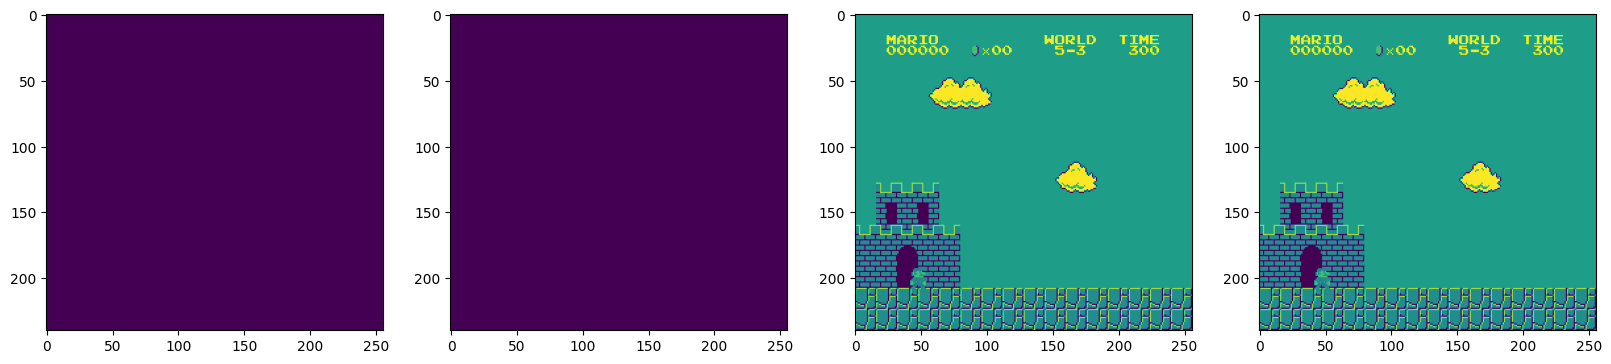

In [8]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# 3. Train the RL Model

In [10]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [13]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [14]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [15]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [16]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

In [17]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/PPO_1


/home/daniel/.local/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 269 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 160           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 3.7710415e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.0151       |
|    learning_rate        | 1e-06         |
|    loss                 | 98.6          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000298     |
|    value_loss           | 365           |
-------------------------------------------
-----

In [18]:
model.save('thisisatestmodel')

# 4. Test it Out

In [11]:
# Load model
model = PPO.load('./train/best_model_1000000')

In [12]:
state = env.reset()

In [13]:
# Start the game 
state = env.reset()
# Loop through the game
for step in range(5000): 
# while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

/home/daniel/.local/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256
